# grn bench perturb seq

In [2]:
from scprint import scPrint
from scdataloader import Preprocessor
from scprint.tasks import GRNfer

from bengrn import BenGRN, get_sroy_gt, get_perturb_gt

from bengrn.base import train_classifier

from anndata.utils import make_index_unique
from bengrn import compute_genie3, compute_scenic
from grnndata import utils as grnutils

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:53: DeprecationWarning: jax.core.Shape is deprecated. Use Shape = Sequence[int | Any].
  Shape = jax.core.Shape
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:54: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  PRNGKey = jax.random.KeyArray


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_types.py:9: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  IntOrKey = Union[int, jax.random.KeyArray]
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/utils/_utils.py:40: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  def validate_seed(seed: IntOrKey) -> jax.random.KeyArray:
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metri

In [4]:
adata = get_perturb_gt()

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/gem_group' was written without encoding metadata.
  return func(*args, **kwargs)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/uti

In [5]:
adata.var["isTF"]=False
adata.var.loc[adata.var.gene_name.isin(grnutils.TF), "isTF"]=True
adata.var["isTF"].sum()

650

In [6]:
preprocessor = Preprocessor(force_preprocess=True, skip_validate=True, do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)

In [7]:
nadata = preprocessor(adata.copy())
adata

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 10691 renamining
filtered out 0 cells, 10691 renamining
Removed 8 genes.
startin QC
Seeing 10068 outliers (94.17% of total dataset):
done


GRnnData object with n_obs × n_vars = 10691 × 8563
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'organism_ontology_term_id'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'isTF'
    varp: 'GRN'
    with a grn of 1115065 elements

In [3]:
model = scPrint.load_from_checkpoint('../../data/temp/vbd8bavn/epoch=17-step=90000.ckpt', precpt_gene_emb = None)#'../../data/main/gene_embeddings.parquet')


In [4]:
print(model)

scPrint(
  (gene_encoder): GeneEncoder(
    (embedding): Embedding(44756, 256)
  )
  (expr_encoder): ContinuousValueEncoder(
    (encoder): ModuleList(
      (0): Linear(in_features=1, out_features=256, bias=True)
      (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=256, out_features=256, bias=True)
    )
  )
  (pos_encoder): PositionalEncoding()
  (class_encoder): CategoryValueEncoder(
    (embedding): Embedding(7, 256)
  )
  (depth_encoder): ContinuousValueEncoder(
    (encoder): ModuleList(
      (0): Linear(in_features=1, out_features=256, bias=True)
      (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=256, out_features=256, bias=True)
    )
  )
  (transformer): FlashTransformerEncoder(
    (blocks): ModuleList(
      (0): Block(
        (mixer): MHA(
          (Wqkv): Linear(in_feat

In [ ]:
grn_inferer = GRNfer(model, nadata,
    how="most var within",
    preprocess="softmax",
    head_agg='max',
    filtration="none",
    forward_mode="none",
    organisms=adata.obs['organism_ontology_term_id'][0],
    apc=False,
    symmetrize=False,
    num_genes=8000,
    max_cells=2048,
    doplot=False,
    batch_size=32,
)
grn = grn_inferer(layer=list(range(model.nlayers))[:])

/tmp/ipykernel_476594/2512011377.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


number of expressed genes in this cell type: 8555


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:169: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

> /home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py(220)aggregate()
    218         import pdb
    219         pdb.set_trace()
--> 220         attns = None
    221         Qs = (
    222             attn[:, :, 0, :, :]

avg link count: 11580409, sparsity: 1.0


... storing 'organism_ontology_term_id' as categorical
... storing 'symbol' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'description' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.024526533666042887 
recall:  1.0 
random precision: 0.024534246412478748


 97%|█████████▋| 96/99 [00:02<00:00, 57.93it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:662: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:02<00:00, 43.78it/s]


Area Under Precision-Recall Curve (AUPRC):  0.032333111795246505
EPR: 2.0352732909347626


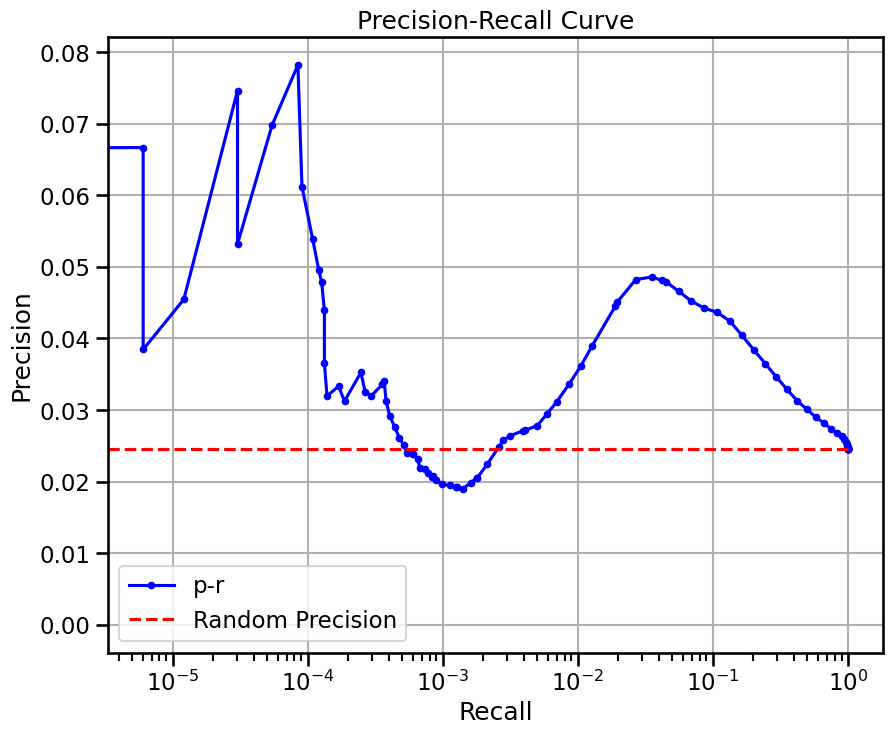

{'precision': 0.024526533666042887,
 'recall': 1.0,
 'rand_precision': 0.024534246412478748,
 'auprc': 0.032333111795246505,
 'EPR': 2.0352732909347626}

In [21]:
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)

In [9]:
grn_inferer = GRNfer(model, nadata,
    how="most var within",
    preprocess="softmax",
    head_agg='none',
    filtration="none",
    forward_mode="none",
    organisms=adata.obs['organism_ontology_term_id'][0],
    apc=False,
    symmetrize=False,
    num_genes=8000,
    max_cells=1024,
    doplot=False,
    batch_size=32,
)
grn = grn_inferer(layer=list(range(model.nlayers))[:])

/tmp/ipykernel_518725/2620532829.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


number of expressed genes in this cell type: 8555


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:169: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

... storing 'organism_ontology_term_id' as categorical
... storing 'symbol' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'description' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


In [10]:
grn.var['ensembl_id'] = grn.var.index

pred shape (2116, 3181, 32)
true elem 165088 ...
doing regression....
metrics {'used_heads': 23, 'precision': 0.11529505582137162, 'random_precision': 0.024868317112005055, 'recall': 0.06169562694159014, 'predicted_true': 62700, 'number_of_true': 117172, 'epr': 4.818545852592731}


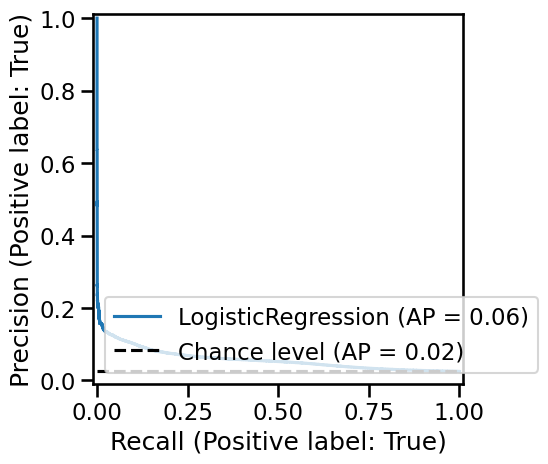

In [11]:
grn, m = train_classifier(grn, other=adata, C=0.1, train_size=0.3, class_weight={1: 20, 0: 1}, shuffle=False, use_col="ensembl_id", )

precision:  0.024526533666042887 
recall:  1.0 
random precision: 0.024534246412478748


 95%|█████████▍| 94/99 [00:02<00:00, 47.05it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:671: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:02<00:00, 34.56it/s]


Area Under Precision-Recall Curve (AUPRC):  0.05636392903644662
EPR: 4.747073497806698


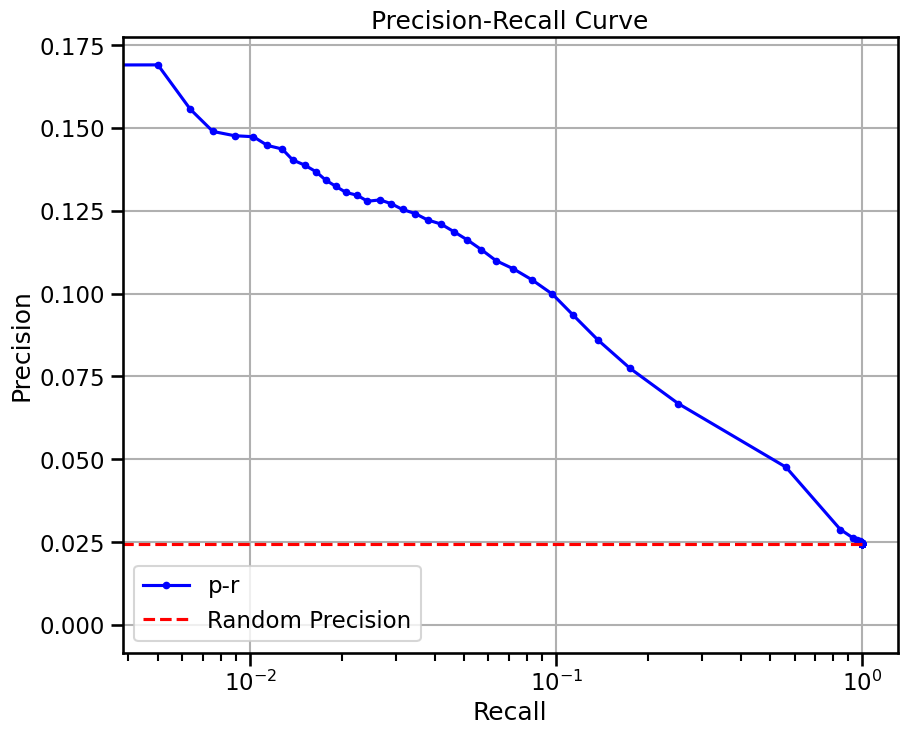

{'precision': 0.024526533666042887,
 'recall': 1.0,
 'rand_precision': 0.024534246412478748,
 'auprc': 0.05636392903644662,
 'EPR': 4.747073497806698}

In [13]:
grn.varp['GRN'] = grn.varp['classified']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)

pred shape (2116, 3181, 32)
true elem 165088 ...
doing regression....
metrics {'used_heads': 24, 'precision': 0.11526572514321366, 'random_precision': 0.024868317112005055, 'recall': 0.06937664288396546, 'predicted_true': 70524, 'number_of_true': 117172, 'epr': 4.950568171911562}


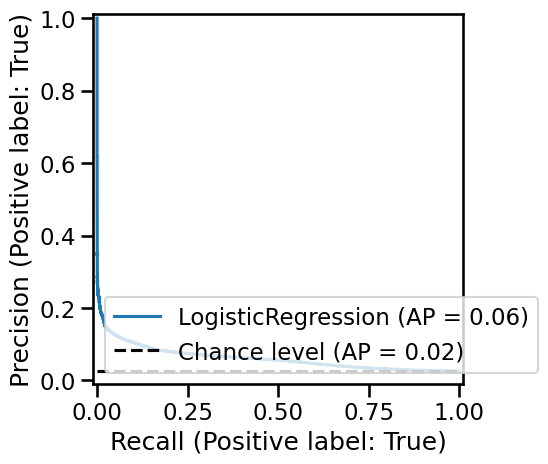

In [49]:
grn, m = train_classifier(grn, other=adata, C=0.1, train_size=0.3, class_weight={1: 20, 0: 1}, shuffle=False, use_col="ensembl_id")

In [9]:
adata.var["symbol"] = adata.var["gene_name"]
adata.var['ensembl_id'] = adata.var.index

In [21]:
genie_grn = compute_genie3(adata[:1024,adata.var.index.isin(grn_inferer.curr_genes)], nthreads=32, regulators=adata.var[adata.var.isTF].index.tolist())

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 32 threads


Elapsed time: 59.62 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


In [23]:
genie_grn.var = genie_grn.var.set_index('ensembl_id')

precision:  0.018461121513747906 
recall:  0.052886040569726574 
random precision: 0.024692739377461744


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:665: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
 45%|████▌     | 45/99 [00:01<00:01, 48.06it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:671: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:02<00:00, 48.14it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0221132199588148
EPR: 1.044110552334185


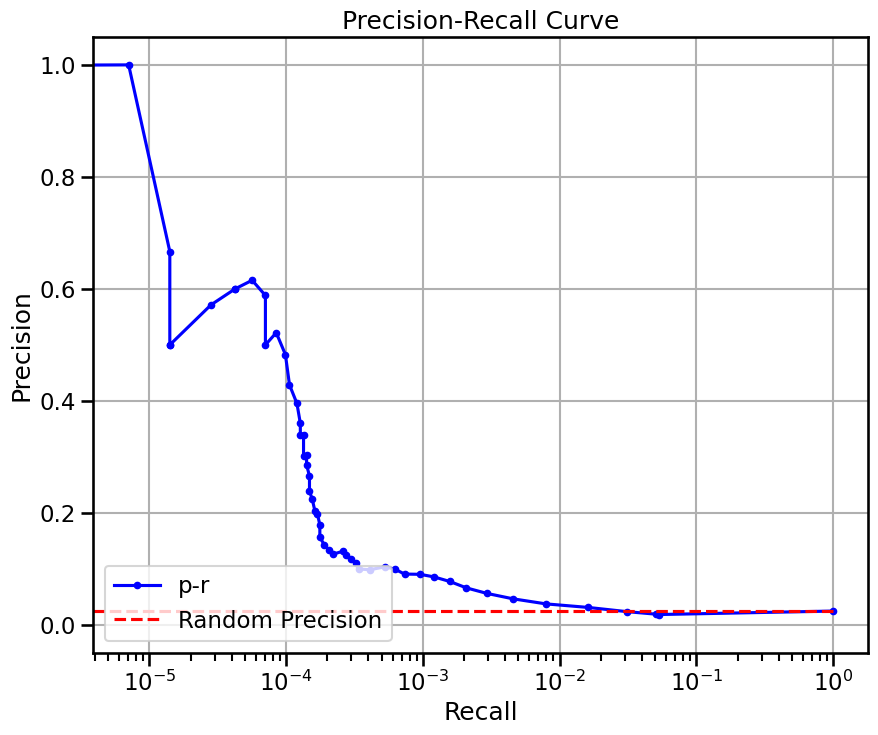

{'precision': 0.018461121513747906,
 'recall': 0.052886040569726574,
 'rand_precision': 0.024692739377461744,
 'auprc': 0.0221132199588148,
 'EPR': 1.044110552334185}

In [26]:
BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=adata)

In [27]:
genie_grn = compute_genie3(adata[:1024], nthreads=32)
BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=adata)

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 32 threads
Elapsed time: 963.46 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


da is very small:  0


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:641: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] != 0).sum() / (grn != 0).sum()
/home/ml4ig1/Documents code/benGRN/bengrn/base.py:642: RuntimeWarning: invalid value encountered in long_scalars
  recall = (grn[true] != 0).sum() / true.sum()
/home/ml4ig1/Documents code/benGRN/bengrn/base.py:643: RuntimeWarning: invalid value encountered in long_scalars
  rand_prec = true.sum() / tot


precision:  nan 
recall:  nan 
random precision: nan


ValueError: zero-size array to reduction operation minimum which has no identity

In [30]:
genie_grn.var = genie_grn.var.set_index('ensembl_id')

In [32]:
genie_grn = compute_genie3(adata[:1024, adata.var.index.isin(grn_inferer.curr_genes)], nthreads=32)


Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 32 threads
Elapsed time: 202.75 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


precision:  0.024749253393938575 
recall:  0.9828983215934275 
random precision: 0.024692739377461744


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:665: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
 47%|████▋     | 47/99 [00:01<00:01, 33.03it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:671: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:02<00:00, 40.12it/s]


Area Under Precision-Recall Curve (AUPRC):  0.05208421904681078
EPR: 3.50051527608726


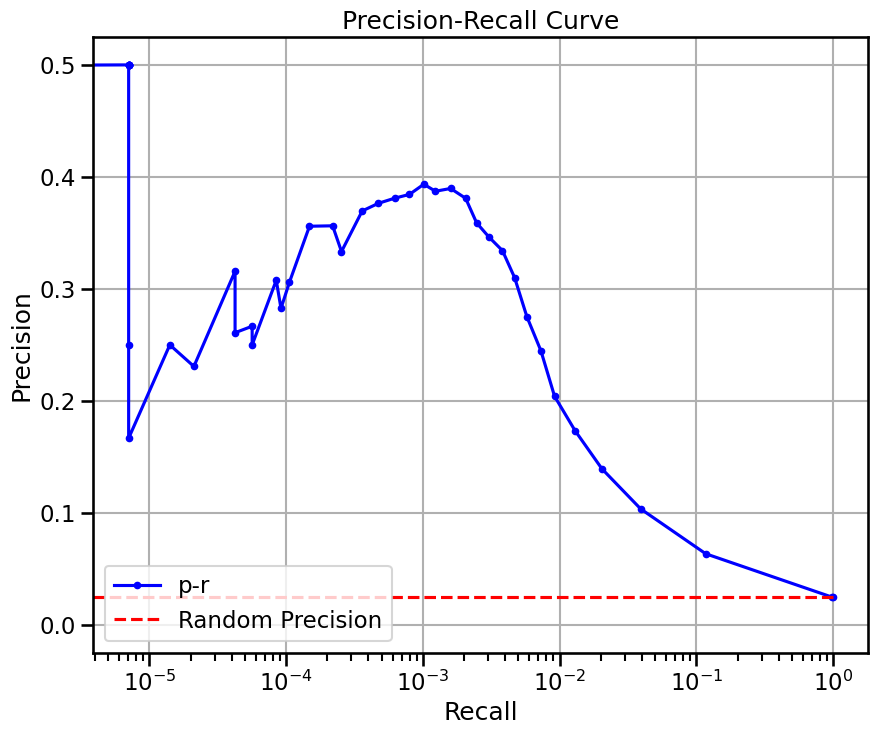

{'precision': 0.024749253393938575,
 'recall': 0.9828983215934275,
 'rand_precision': 0.024692739377461744,
 'auprc': 0.05208421904681078,
 'EPR': 3.50051527608726}

In [33]:
genie_grn.var = genie_grn.var.set_index('ensembl_id')
BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=adata)